In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from astropy.visualization import ZScaleInterval
import matplotlib

%matplotlib inline

In [2]:
wisps.POLYNOMIAL_RELATIONS

{'snr_F110W': poly1d([-0.24733259,  6.62827215]),
 'snr_F140W': poly1d([-0.2671465,  7.098545 ]),
 'snr_F160W': poly1d([-0.24944873,  6.68969987]),
 'sp_F110W': poly1d([-3.17452276e-06,  5.08637834e-04, -3.34269782e-02,  1.15206906e+00,
        -2.19517527e+01,  2.19597212e+02, -8.91384270e+02]),
 'sigma_log_f110': 0.42819868018721347,
 'sigma_log_f140': 0.4668121918409931,
 'sigma_log_f160': 0.4525423819285358,
 'sp_F140W': poly1d([ 3.49700571e-06, -5.38160346e-04,  3.39775057e-02, -1.12587153e+00,
         2.06379050e+01, -1.98034222e+02,  7.85333071e+02]),
 'sp_F160W': poly1d([ 2.95894023e-06, -4.55984286e-04,  2.88289790e-02, -9.56244494e-01,
         1.75370703e+01, -1.68252334e+02,  6.67704101e+02])}

In [3]:
df=wisps.datasets['candidates']

In [4]:
#wisps.POLYNOMIAL_RELATIONS

In [5]:
df=df[df.spt.apply(splat.typeToNum)>19.0]

In [6]:
df['spectra']=df.grism_id.apply(lambda x: wisps.Source(name=x))

In [7]:
df['spt']=df['spectra'].apply(lambda x: x.spt)

In [8]:
df=df.sort_values(by='spt').reset_index(drop=True)

In [9]:
def plot_image(sp, ax, cmap='viridis'):
     # mapping between filters and images
    image_data_dict={'F140W' : sp.photo_image.f140,
                'F160W': sp.photo_image.f160,
                'F110W': sp.photo_image.f110}
    try:
        image_key_to_use=[ k for k in image_data_dict.keys() if image_data_dict[k]['grid'] is not None  ][0]
    except:
        image_key_to_use='F140W'

    
    mag_in_filter=np.round(sp.mags[image_key_to_use][0])
    image_data=image_data_dict[image_key_to_use]
    
    image=image_data['data']
    vmin, vmax=ZScaleInterval().get_limits( image)
    norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
    
    ax.pcolormesh(image_data['grid'][0], image_data['grid'][1], 
                   image_data['data'], cmap=cmap,
                   vmin=vmin, vmax=vmax, rasterized=True, alpha=1.0)
    
    ax.plot(image_data['center'][0], 
             image_data['center'][1], marker='+',c='#111111', ms=30)

In [10]:
from matplotlib import gridspec

In [11]:
gs = gridspec.GridSpec(len(df), 3,width_ratios=[2., .5, 2.])

In [12]:
10*1.5

15.0

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


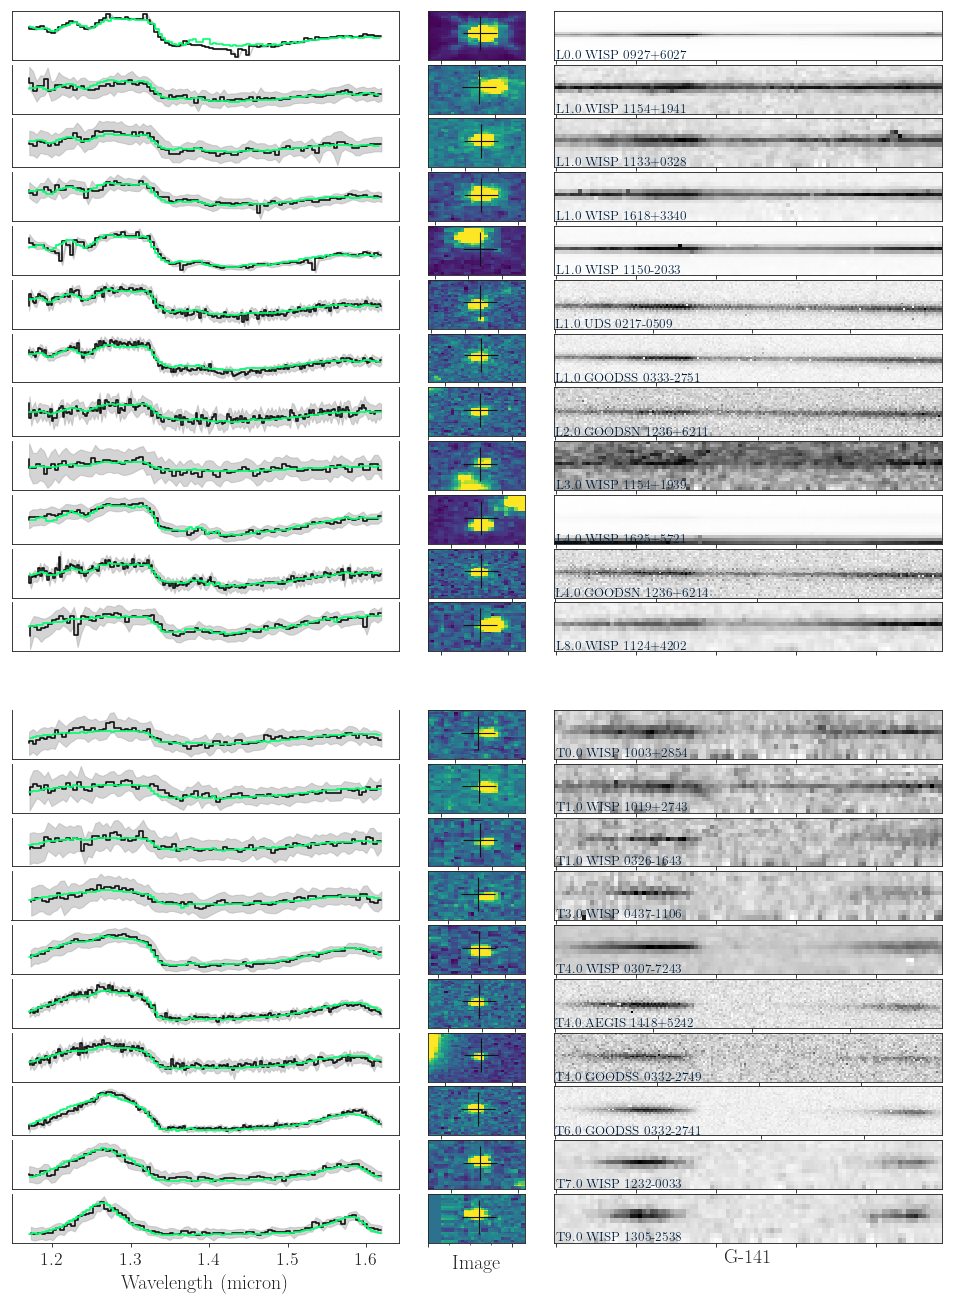

In [13]:
#fig, ax=plt.subplots(nrows=len(df),ncols=3,  width_ratios=[3, 1, 3], figsize=(8*1.5, 8*1.5), sharex=False, sharey=False)

fig = plt.figure(figsize=(10*1.5, 20)) 

for idx, row in df.iterrows():
 s=row.spectra
 if splat.typeToNum(s.spt)> 19:
    s.normalize(waverange=[1.17,1.62])
    std=splat.STDS_DWARF_SPEX[s.spt]
    std.normalize(waverange=[1.17,1.62])
    #s.normalize()
    mask=np.where((s.wave>1.17) & (s.wave<1.62))[0]
    mask2=np.where((std.wave.value>1.17) & (std.wave.value<1.62))[0]
    a=None
    
    #print (idx)
    a=plt.subplot(gs[idx, 0])
    
    
    
    a.step(s.wave[mask], s.flux[mask], color='#111111')
    un, sc=splat.compareSpectra(s.splat_spectrum, std, fit_range=[1.15, 1.65])
    std.scale(sc)
    a.step(std.wave[mask2], std.flux[mask2],color='#01FF70' )
    
    a.fill_between(s.wave[mask],s.flux[mask]-3.*s.noise[mask], \
                   s.flux[mask]+3.*s.noise[mask], alpha=.5,color='#AAAAAA')
    
    b=plt.subplot(gs[idx, 2])
    b.imshow(s.spectrum_image.T[mask].T, cmap='Greys', interpolation='nearest')
    b.set_aspect('auto')
    
    c=plt.subplot(gs[idx,1])
    
    plot_image(s, c)
   
    
    if idx == 0:
        #a.spines['bottom'].set_visible(False)
        a.set_xticks([]) 
        a.set_yticks([])
        
    elif idx == len(df)-1:
        a.spines['top'].set_visible(False)
        a.set_yticks([])
        a.set_xlabel('Wavelength (micron)', fontsize=18)
        b.set_xlabel('G-141', fontsize=18)
        c.set_xlabel('Image', fontsize=18)
        
    else :
        a.spines['top'].set_visible(False)
        #a.spines['bottom'].set_visible(False)
        a.set_xticks([]) 
        a.set_yticks([])
        
    if row.spt.lower().startswith('t'): b.text(0.0,s.spectrum_image.shape[0]-1,row.spt +' '+ s.shortname, fontsize=12, color='#001f3f')
    if row.spt.lower().startswith('l') or row.spt.lower().startswith('m'): 
        b.text(0.0, s.spectrum_image.shape[0]-1,row.spt +' '+ s.shortname, fontsize=12, color='#001f3f')
        
    b.set_yticks([])
    b.tick_params(labelbottom=False)
    
    c.set_yticks([])
    c.tick_params(labelbottom=False)



plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
plt.minorticks_on()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidates.pdf')

In [14]:
df['distance']=df.spectra.apply(lambda x: x.distance['val'].value)

In [15]:
#df['distance']

In [16]:
fdf=df

In [17]:
fdf.drop(['spectra', 'exposure'], axis=1).to_latex(wisps.LIBRARIES+'/candidates2.tex', index=False, na_rep=' ' )

In [18]:
#distance distributions
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import astropy.units as u
coords=SkyCoord(ra=fdf.RA.values*u.deg, dec=fdf.DEC.values*u.deg, distance=fdf.distance.values*u.pc)#.transform_to(coord.Galactocentric) 

In [19]:
x, y, z=coords.cartesian.xyz

In [20]:
r=np.sqrt(x**2+y**2)

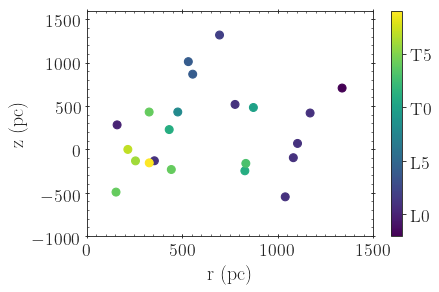

In [21]:
fig, ax=plt.subplots(figsize=(6, 4))
sc=plt.scatter(r, z, c=fdf.spt.apply(splat.typeToNum), cmap='viridis', s=50)
br=plt.colorbar(sc)
plt.ylabel('z (pc)', fontsize=18)
plt.xlabel('r (pc)', fontsize=18)
ax.set_xticks(np.arange(0, 2000, 50), minor=True)
ax.set_yticks(np.arange(-1000, 2500, 100), minor=True)

ax.set_xlim([0, 1500])
ax.set_ylim([-1000, 1600])

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.tick_params(which='major',direction='inout')
ax.tick_params(which='minor', direction='in')

br.set_ticks([20, 25, 30, 35, 40])
br.set_ticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/candidate_distances.pdf')

In [22]:
mags=wisps.Annotator.reformat_table(pd.DataFrame.from_records(df.spectra.apply(lambda x: x.mags).values))

In [23]:
#mags

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


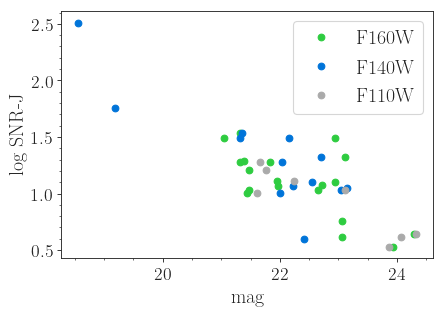

In [24]:
import seaborn as sns
fig, ax=plt.subplots(figsize=(6, 4))
ax.errorbar(mags.F160W,  fdf.snr1.apply(np.log10),fmt='o', color='#2ECC40', label='F160W' )
ax.errorbar(mags.F140W,   fdf.snr1.apply(np.log10),fmt='o', color='#0074D9', label='F140W')
ax.errorbar(mags.F110W,   fdf.snr1.apply(np.log10),fmt='o', color='#AAAAAA' , label='F110W')
#plt.xlabel('mag', fontsize=16)

plt.minorticks_on()
#ax.yaxis.set_ticks_position('both')
#ax.xaxis.set_ticks_position('both')
#ax.tick_params(which='major',direction='inout')
#ax.tick_params(which='minor', direction='in')

plt.legend()

plt.xlabel('mag', fontsize=18)
plt.ylabel('log SNR-J', fontsize=18)
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_distribution_candidates.pdf')

In [25]:
dhgjk=fdf.sort_values(by='distance')[['grism_id', 'distance', 'spt']]

In [26]:
finalfinaldf=wisps.Annotator.reformat_table(wisps.datasets['stars'][wisps.datasets['stars'].grism_id.isin(fdf.grism_id)])

In [27]:
#\tablehead{\colhead{Short Name} & 
#           \nocolhead{Grism ID} & \colhead{SNR-J} & \colhead{SpT} &\nocolhead{RA }& 
#           \nocolhead{DEC} &  \nocolhead{F110W}& \nocolhead{F110Wer} &  
#           \nocolhead{F140W} &  \nocolhead{F140Wer} & 
#           \colhead{F160W} &\nocolhead{F160Wer } &\colhead{Distance (pc)} & 
#           \nocolhead{Distance error} }

In [28]:
int(round(fdf.spectra.iloc[0].snr['snr1']))

324

In [29]:
latc_df=pd.DataFrame()

In [30]:
latc_df['Shortname']=fdf.spectra.apply(lambda x: x.shortname.upper())
latc_df['grism id']=fdf.spectra.apply(lambda x: x.name.upper())
latc_df['snrj']=fdf.spectra.apply(lambda x: int(round(x.snr['snr1'])))
latc_df['spt']=fdf.spectra.apply(lambda x: x.spt.upper().replace('.0', ''))
latc_df['ra']=fdf.spectra.apply(lambda x: x.ra.value)
latc_df['dec']=fdf.spectra.apply(lambda x: x.dec.value)
latc_df['f110']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][0], 1))
latc_df['f110_er']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][1], 1))
latc_df['f140']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][0],1))
latc_df['f140_er']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][1], 1))
latc_df['f160']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][0], 1))
latc_df['f160_er']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][1], 1))
latc_df['distance']=fdf.spectra.apply(lambda x: int(round(x.distance['val'].value)))
latc_df['distance_er']=fdf.spectra.apply(lambda x: int(round(x.distance['er'].value)))



In [31]:
latc_df=latc_df[latc_df.spt.apply(splat.typeToNum)> 19.]

In [32]:
latc_df

,Shortname,grism id,snrj,spt,ra,dec,f110,f110_er,f140,f140_er,f160,f160_er,distance,distance_er
0,WISP 0927+6027,PAR21-00005,324,L0,141.989319,60.462970,NaN,NaN,18.6,0.0,NaN,NaN,324,7
1,WISP 1154+1941,PAR338-00035,13,L1,178.716644,19.684700,22.2,0.0,NaN,NaN,21.9,0.0,1243,532
2,WISP 1133+0328,PAR27-00036,10,L1,173.274353,3.477643,21.6,0.0,22.0,0.0,21.4,0.0,1106,406
3,WISP 1618+3340,PAR65-00035,19,L1,244.707458,33.671520,21.7,0.0,NaN,NaN,21.3,0.0,934,390
4,WISP 1150-2033,PAR199-00009,57,L1,177.706833,-20.561000,NaN,NaN,19.2,0.0,NaN,NaN,379,7
5,UDS 0217-0509,UDS-25-G141_36758,31,L1,34.318333,-5.153692,NaN,NaN,21.3,0.0,21.0,0.0,1086,81
6,GOODSS 0333-2751,GOODSS-28-G141_10859,34,L1,53.267498,-27.860249,NaN,NaN,21.4,0.0,21.3,0.0,1176,153
7,GOODSN 1236+6211,GOODSN-33-G141_09283,12,L2,189.223923,62.188259,NaN,NaN,22.2,0.0,22.0,0.0,1491,130
8,WISP 1154+1939,PAR338-00136,4,L3,178.720154,19.660000,24.1,0.0,NaN,NaN,23.1,0.0,1807,659
9,WISP 1625+5721,PAR156-00041,19,L4,246.353882,57.357600,NaN,NaN,NaN,NaN,21.4,0.0,1029,15


In [33]:
len(latc_df[latc_df.spt.str.startswith('T')]), len(latc_df[latc_df.spt.str.startswith('L')])

(10, 12)

In [34]:
latc_df.to_latex(wisps.LIBRARIES+'/candidates.tex',
             header=True, index=False, na_rep=' ')

In [45]:
%%capture 
fold='/Users/caganze/research/wisps/figures/ltwarfs/'

ids=0
for idx, row in df.iterrows():
    s=row.spectra
    
    if splat.typeToNum(s.spt)> 19:
        filename=fold+'spectrum'+str(ids)+'.pdf'
        s.plot(save=True, filename=filename)
        ids=ids+1